In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import batman

import astropy.units as u
from astropy.timeseries import BoxLeastSquares
from scipy.optimize import curve_fit

import emcee
import corner

In [938]:
import photoeccentric as ph

%load_ext autoreload
%autoreload 2

pd.set_option("display.max_rows", None, "display.max_columns", None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [907]:
#Kepler planets with spectroscopy
rho_lum = pd.read_csv('/Users/sheilasagear/Dropbox (UFL)/Research/MetallicityProject/Data/rhos/rho_lum.csv')

# ALL Kepler planets from exo archive
planets = pd.read_csv('/Users/sheilasagear/Dropbox (UFL)/Research/MetallicityProject/Data/exoplanetarchive/cumulative_kois.csv')

# Take the Kepler planet archive entries for the planets we have spectroscopy for
spectplanets = planets[planets['kepid'].isin(list(rho_lum.columns))]
spectplanets = spectplanets.reset_index()

In [908]:
spectplanets

,index,kepid,kepoi_name,kepler_name,koi_disposition,koi_vet_stat,koi_vet_date,koi_pdisposition,koi_score,koi_fpflag_nt,...,koi_dicco_mdec,koi_dicco_mdec_err,koi_dicco_msky,koi_dicco_msky_err,koi_dikco_mra,koi_dikco_mra_err,koi_dikco_mdec,koi_dikco_mdec_err,koi_dikco_msky,koi_dikco_msky_err
0,64,11923270,K00781.01,Kepler-676 b,CONFIRMED,Done,8/16/18,CANDIDATE,1.000,0,...,-0.03,0.082,0.066,0.095,0.29,0.110,0.628,0.080,0.690,0.086
1,85,4139816,K00812.02,Kepler-235 d,CONFIRMED,Done,8/16/18,CANDIDATE,1.000,0,...,-0.03,0.140,0.030,0.140,-0.18,0.140,-0.150,0.140,0.230,0.140
2,86,4139816,K00812.03,Kepler-235 e,CONFIRMED,Done,8/16/18,CANDIDATE,1.000,0,...,0.04,0.220,0.080,0.210,-0.25,0.170,-0.060,0.160,0.260,0.170
3,88,4139816,K00812.04,Kepler-235 c,CONFIRMED,Done,8/16/18,CANDIDATE,0.994,0,...,-0.45,0.390,0.550,0.350,0.11,0.300,-0.580,0.430,0.590,0.400
4,105,4139816,K00812.01,Kepler-235 b,CONFIRMED,Done,8/16/18,CANDIDATE,1.000,0,...,0.05,0.097,0.060,0.110,-0.15,0.092,-0.039,0.092,0.154,0.092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,7186,5384713,K03444.04,NaN,CANDIDATE,Done,8/16/18,CANDIDATE,0.000,0,...,1.20,0.720,1.210,0.730,0.21,0.930,1.570,0.890,1.580,0.910
93,7588,10122538,K02926.03,Kepler-1388 d,CONFIRMED,Done,8/16/18,CANDIDATE,1.000,0,...,-0.06,0.190,0.140,0.210,-0.10,0.100,-0.180,0.230,0.210,0.210
94,7606,10122538,K02926.04,Kepler-1388 e,CONFIRMED,Done,8/16/18,CANDIDATE,1.000,0,...,0.15,0.220,0.250,0.220,-0.02,0.220,0.000,0.200,0.020,0.220
95,8590,11129738,K01427.02,NaN,CANDIDATE,Done,8/16/18,CANDIDATE,0.891,0,...,1.05,0.460,1.140,0.460,-0.35,0.460,0.810,0.460,0.880,0.460


In [939]:
#kepname = "Kepler-676 b"

In [940]:
spectplanets.loc[spectplanets['kepid'] == 5868793]

,index,kepid,kepoi_name,kepler_name,koi_disposition,koi_vet_stat,koi_vet_date,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_disp_prov,koi_comment,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,koi_time0,koi_time0_err1,koi_time0_err2,koi_eccen,koi_eccen_err1,koi_eccen_err2,koi_longp,koi_longp_err1,koi_longp_err2,koi_impact,koi_impact_err1,koi_impact_err2,koi_duration,koi_duration_err1,koi_duration_err2,koi_ingress,koi_ingress_err1,koi_ingress_err2,koi_depth,koi_depth_err1,koi_depth_err2,koi_ror,koi_ror_err1,koi_ror_err2,koi_srho,koi_srho_err1,koi_srho_err2,koi_fittype,koi_prad,koi_prad_err1,koi_prad_err2,koi_sma,koi_sma_err1,koi_sma_err2,koi_incl,koi_incl_err1,koi_incl_err2,koi_teq,koi_teq_err1,koi_teq_err2,koi_insol,koi_insol_err1,koi_insol_err2,koi_dor,koi_dor_err1,koi_dor_err2,koi_limbdark_mod,koi_ldm_coeff4,koi_ldm_coeff3,koi_ldm_coeff2,koi_ldm_coeff1,koi_parm_prov,koi_max_sngle_ev,koi_max_mult_ev,koi_model_snr,koi_count,koi_num_transits,koi_tce_plnt_num,koi_tce_delivname,koi_quarters,koi_bin_oedp_sig,koi_trans_mod,koi_model_dof,koi_model_chisq,koi_datalink_dvr,koi_datalink_dvs,koi_steff,koi_steff_err1,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_smet,koi_smet_err1,koi_smet_err2,koi_srad,koi_srad_err1,koi_srad_err2,koi_smass,koi_smass_err1,koi_smass_err2,koi_sage,koi_sage_err1,koi_sage_err2,koi_sparprov,ra,dec,koi_kepmag,koi_gmag,koi_rmag,koi_imag,koi_zmag,koi_jmag,koi_hmag,koi_kmag,koi_fwm_stat_sig,koi_fwm_sra,koi_fwm_sra_err,koi_fwm_sdec,koi_fwm_sdec_err,koi_fwm_srao,koi_fwm_srao_err,koi_fwm_sdeco,koi_fwm_sdeco_err,koi_fwm_prao,koi_fwm_prao_err,koi_fwm_pdeco,koi_fwm_pdeco_err,koi_dicco_mra,koi_dicco_mra_err,koi_dicco_mdec,koi_dicco_mdec_err,koi_dicco_msky,koi_dicco_msky_err,koi_dikco_mra,koi_dikco_mra_err,koi_dikco_mdec,koi_dikco_mdec_err,koi_dikco_msky,koi_dikco_msky_err
81,3918,5868793,K04290.01,Kepler-1582 b,CONFIRMED,Done,8/16/18,CANDIDATE,0.914,0,0,0,0,q1_q17_dr25_sup_koi,CENT_KIC_POS,4.838095,0.000088,-0.000088,135.1562,0.0107,-0.0107,2454968.156,0.0107,-0.0107,0.0,NaN,NaN,NaN,NaN,NaN,0.014,0.438,-0.014,1.096,0.135,-0.135,NaN,NaN,NaN,1540.0,169.0,-169.0,0.036066,0.00267,-0.00205,34.49907,6.04453,-22.50309,LS+MCMC,0.79,0.12,-0.12,0.0316,NaN,NaN,89.98,NaN,NaN,354.0,NaN,NaN,3.7,1.58,-1.31,34.95,6.1,-6.1,Claret (2011 A&A 529 75) ATLAS LS,0.0,0.0,0.3411,0.3866,q1_q17_dr25_koi,3.337935,10.980496,11.3,1,70.0,1.0,q1_q17_dr25_tce,1.111000e+26,0.189,Mandel and Agol (2002 ApJ 580 171),NaN,NaN,005/005868/005868793/dv/kplr005868793-20160209...,005/005868/005868793/dv/kplr005868793-001-2016...,3187.0,62.0,-88.0,5.091,0.01,-0.01,0.1,0.16,-0.16,0.2,0.03,-0.03,0.18,0.04,-0.04,NaN,NaN,NaN,q1_q17_dr25_stellar,289.37668,41.158672,17.058,18.174,17.041,16.578,NaN,13.285,12.694,12.435,0.088,19.291803,0.000027,41.15801,0.00033,1.0,1.1,-2.4,1.2,-0.0022,0.0019,0.0013,0.0021,-0.04,0.28,0.6,0.27,0.6,0.27,-0.33,0.24,-1.0,0.29,1.05,0.29


In [941]:
smass, smass_uerr, smass_lerr, srad, srad_uerr, srad_lerr, ldmod, ldm_c1, ldm_c2 = ph.stellar_params_from_archive(spectplanets, kepname)
period, period_uerr, period_lerr, rprs, rprs_uerr, rprs_lerr, a, a_uerr, a_lerr, i, e, w = ph.planet_params_from_archive(spectplanets, kepname)

smass_err = np.mean((smass_uerr, np.abs(smass_lerr)))
srad_err = np.mean((srad_uerr, np.abs(srad_lerr)))
period_err = np.mean((period_uerr, np.abs(period_lerr)))
rprs_err = np.mean((rprs_uerr, np.abs(rprs_lerr)))
a_err = np.mean((a_uerr, np.abs(a_lerr)))

smass = 0.22
srad = 0.24

print('Stellar mass: ', smass, 'Stellar radius: ', srad)
print('Period: ', period, 'Rp/Rs: ', rprs)
print('a: ', a)
print('i: ', i)

Stellar mass:  0.22 Stellar radius:  0.24
Period:  11.59822233 Rp/Rs:  0.051287
a:  28.2
i:  88.62


In [910]:
""" Create arrays (stopped here 1/27/21)"""


""" Create mass and radius arrays """

masses_dist = [np.random.normal(smass, np.mean((smass_uerr, np.abs(smass_lerr))), size=100)]
radii_dist = [np.random.normal(srad, np.mean((srad_uerr, np.abs(srad_lerr))), size=100)]
period_dist = [np.random.normal(period, np.mean((period_uerr, np.abs(period_lerr))), size=100)]
rprs_dist = [np.random.normal(rprs, np.mean((rprs_uerr, np.abs(rprs_lerr))), size=100)]
a_dist = [np.random.normal(a, np.mean((a_uerr, np.abs(a_lerr))), size=100)]

###### Find the density of this "star" based on available information (mass and radius)


In [911]:
rho, ms, rs = ph.find_density_dist_symmetric(1, [smass], [smass_err], [srad], [srad_err])
rho[0].flatten();
rhos = rho[0]
rho_minuserr, rho_pluserr = ph.get_sigmas(rhos)

print('Mean density: ', np.mean(rhos))

100%|██████████| 1/1 [00:00<00:00, 476.35it/s]

Mean density:  27493.038556486263


##### Create a transit model with planet params above.

In [912]:
time = np.linspace(-24, 24, 10000)

In [913]:
def planetlc(time, per, rp, a, inc):
    params = batman.TransitParams()       #object to store transit parameters
    params.t0 = 0.                        #time of inferior conjunction
    params.per = per                      #orbital period
    params.rp = rp                        #planet radius (in units of stellar radii)
    params.a = a                          #semi-major axis (in units of stellar radii)
    params.inc = inc                      #orbital inclination (in degrees)
    params.ecc = 0.0
    params.w = 0.0                        #longitude of periastron (in degrees)
    #params.limb_dark = "linear"
    #params.u = [0.3]
    params.limb_dark = "quadratic"
    params.u = [0.1, 0.3]
    #params.limb_dark = "uniform"
    #params.u = []

    #times to calculate light curve
    m = batman.TransitModel(params, time)
    
    flux = m.light_curve(params)
    
    return flux

In [914]:
flux = planetlc(time, period, rprs, a, i)
#nflux = flux

# Adding gaussian noise
noise = np.random.normal(0,0.00005,len(time))
nflux = flux+noise

## Fit transit

#### Astropy BLS

In [915]:
mod = BoxLeastSquares(time*u.day, nflux, dy=0.01)
periodogram = mod.autopower(0.2, objective="snr")

In [916]:
periodogram.period = np.asarray(periodogram.period)
per_guess = periodogram.period[int(np.median(np.argmax(periodogram.power)))]

#### Least-squares using BLS period guess

In [917]:
# Normally I would use the BLS depth, ingress+egress, etc. to guess the other planet params 
# but I'm not going to do that right now because I'm just testing my get_g function

p0 = [per_guess, rprs, a, i]
popt, pcov = curve_fit(ph.planetlc_fitter, xdata=time, ydata=nflux, p0=p0)
fit = planetlc(time, *popt)

In [918]:
ttime = time[2470:2530]
tfit = fit[2470:2530]

In [919]:
p = popt[0]*86400 #4.99 days
perr = 0.001*86400

rprs = popt[1] #0.0704 stellar radii
rprserr = 0.001

a = popt[2] #stellar radii

i = popt[3] #degrees 


T14n = ph.get_T14(p, rprs, a, i)
T14err = 0.0001*86400

T23n = ph.get_T23(p, rprs, a, i)
T23err = 0.0001*86400

In [920]:
p/86400.

1.5654114250985407

In [921]:
rprs

0.0483951496842821

In [922]:
i

90.00097846484105

In [923]:
a

16.55327419423264

(-0.1, 0.1)

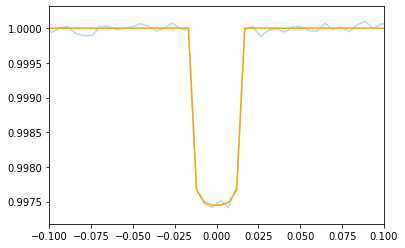

In [924]:
plt.plot(time, nflux, alpha=0.3)
plt.plot(time, fit, c='orange')
plt.xlim(-0.1, 0.1)

In [925]:
gs_t, rhoc, rhoe, T14s, T23s = ph.get_g_distribution(rhos, p, perr, rprs, rprserr, a, i, T14n, T14err, T23n, T23err)
gs = gs_t

g_mean = np.mean(gs)
g_sigma = np.mean(np.abs(ph.get_sigmas(gs)))

100%|██████████| 1000/1000 [00:00<00:00, 58435.21it/s]


In [926]:
g_mean

1.169443257705337

In [927]:
g_sigma

0.21270649561317134

In [928]:
np.mean(rhoe)

27493.038556486263

In [929]:
np.mean(rhoc)

35003.69581936705

In [881]:
#Guesses
w_guess = 0.0
e_guess = 0.0

solnx = (w_guess, e_guess)

In [882]:
pos = solnx + 1e-4 * np.random.randn(32, 2)
nwalkers, ndim = pos.shape

In [883]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, ph.log_probability, args=(g_mean, g_sigma), threads=4)
sampler.run_mcmc(pos, 5000, progress=True);

  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 5000/5000 [00:10<00:00, 497.37it/s]


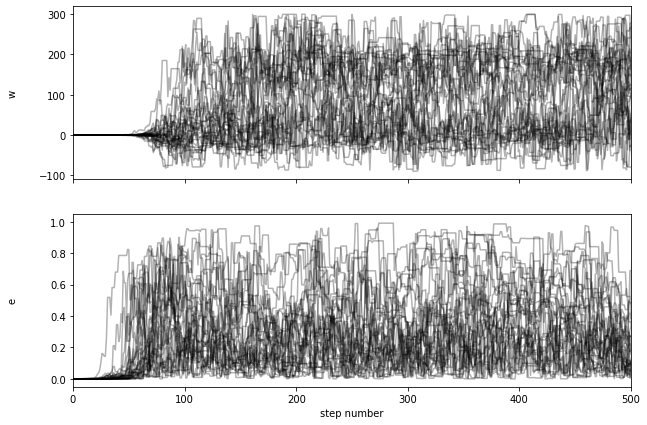

In [884]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["w", "e"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.set_xlim(0, 500)

axes[-1].set_xlabel("step number");

In [753]:
import corner

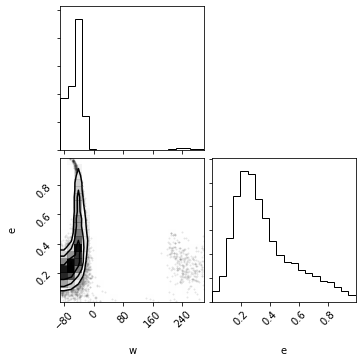

In [754]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
fig = corner.corner(flat_samples, labels=labels)

# Test in sequence

In [808]:
kepname = "Kepler-446 b"

smass, smass_uerr, smass_lerr, srad, srad_uerr, srad_lerr, ldmod, ldm_c1, ldm_c2 = ph.stellar_params_from_archive(spectplanets, kepname)
period, period_uerr, period_lerr, rprs, rprs_uerr, rprs_lerr, a, a_uerr, a_lerr, i, e, w = ph.planet_params_from_archive(spectplanets, kepname)

smass_err = np.mean((smass_uerr, np.abs(smass_lerr)))
srad_err = np.mean((srad_uerr, np.abs(srad_lerr)))
period_err = np.mean((period_uerr, np.abs(period_lerr)))
rprs_err = np.mean((rprs_uerr, np.abs(rprs_lerr)))
a_err = np.mean((a_uerr, np.abs(a_lerr)))


print('Stellar mass: ', smass, 'Stellar radius: ', srad)
print('Period: ', period, 'Rp/Rs: ', rprs)
print('a: ', a)
print('i: ', i)

Stellar mass:  0.32799999999999996 Stellar radius:  0.32799999999999996
Period:  1.5654126130000001 Rp/Rs:  0.048437
a:  16.57
i:  89.99


In [809]:
print(i)

89.99


In [810]:
rho, ms, rs = ph.find_density_dist_symmetric(1, [smass], [smass_err], [srad], [srad_err])
rho[0].flatten();
rhos = rho[0]
rho_minuserr, rho_pluserr = ph.get_sigmas(rhos)

print('Mean density: ', np.mean(rhos))

100%|██████████| 1/1 [00:00<00:00, 244.85it/s]

Mean density:  14406.30692873776


In [811]:
print(i)

89.99


In [815]:
def get_g_fake_transit(rhos, period, period_err, rprs, rprs_err, a, a_err, i):
    
    flux = planetlc(time, period, rprs, a, i)

    # Adding gaussian noise
    noise = np.random.normal(0,0.00005,len(time))
    nflux = flux+noise
    
    mod = BoxLeastSquares(time*u.day, nflux, dy=0.01)
    periodogram = mod.autopower(0.2, objective="snr")

    periodogram.period = np.asarray(periodogram.period)
    per_guess = periodogram.period[int(np.median(np.argmax(periodogram.power)))]

    p0 = [per_guess, rprs, a, i]
    popt, pcov = curve_fit(ph.planetlc_fitter, xdata=time, ydata=nflux, p0=p0)
    fit = planetlc(time, *popt)

    p = popt[0]*86400 #4.99 days
    perr = 0.001*86400

    rprs = popt[1] #0.0704 stellar radii
    rprserr = 0.001

    a = popt[2] #stellar radii

    i = popt[3] #degrees 

    T14n = ph.get_T14(p, rprs, a, i)
    T14err = 0.0001*86400

    T23n = ph.get_T23(p, rprs, a, i)
    T23err = 0.0001*86400

    gs_t, rhoc, rhoe, T14s, T23s = ph.get_g_distribution(rhos, p, perr, rprs, rprserr, a, i, T14n, T14err, T23n, T23err)
    gs = gs_t

    g_mean = np.mean(gs)
    g_sigma = np.mean(np.abs(ph.get_sigmas(gs)))
    
    return g_mean, g_sigma

In [816]:
iters = 100
gs = []
g_sigmas = []

for j in range(iters):
    g, gsig = get_g_fake_transit(rhos, period, period_err, rprs, rprs_err, a, a_err, i)
    gs.append(g)
    g_sigmas.append(gsig)
    

100%|██████████| 1000/1000 [00:00<00:00, 81598.07it/s]


In [817]:
gs

[1.3928563369546603,
 1.3916744602788174,
 1.3903950474436761,
 1.393084567363877,
 1.3914005738738489,
 1.3932206741150195,
 1.391050380633587,
 1.3925318982902513,
 1.3993370553783098,
 1.3918462060483119,
 1.3905653772218234,
 1.392240393634019,
 1.3907662292950025,
 1.391397215594729,
 1.3975493768973233,
 1.3920542202664279,
 1.3917479681777227,
 1.3934655782982694,
 1.3938829132473625,
 1.3916838047713154,
 1.3952008362017863,
 1.4047379921709986,
 1.3957622678928174,
 1.3897356030880015,
 1.3917878565489423,
 1.3903817424568883,
 1.3931365354127976,
 1.3993241987158576,
 1.3883730713969142,
 1.3977130632122812,
 1.398304543758464,
 1.389186591386457,
 1.3898582793047858,
 1.3898348023189637,
 1.3920347940500926,
 1.3913918970277401,
 1.3918087858011174,
 1.3918596142559716,
 1.3898523228804798,
 1.3935650698909434,
 1.3912223069742509,
 1.3968235267100613,
 1.3992853366622384,
 1.3984352355436196,
 1.3923358310309557,
 1.3912691079655948,
 1.3912091641210134,
 1.3978817945519075